# Project: deep Q-learning for Space Invaders

We modified codes from the course notebook for deep Q-learning.

In [1]:
import gym
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import os.path
from datetime import datetime

env = gym.make('SpaceInvaders-v4')

/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
[2017-12-08 15:49:33,461] Making new env: SpaceInvaders-v4


In [2]:
def conv(x, W):
    """simple wrapper for tf.nn.conv2d"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def maxpool(x):
    """simple wrapper for tf.nn.max_pool with stride size 2"""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [ ]:
#Note: Here is the preprocessing suggested by https://www.pinchofintelligence.com/openai-gym-part-3-playing-space-invaders-deep-reinforcement-learning/
def preprocess(obs):
    obs = cv2.cvtColor(cv2.resize(obs,(84, 110)), cv2.COLOR_BGR2GRAY)
    obs = obs[26:110,:]
    ret, obs = cv2.threshold(obs,1,255,cv2.THRESH_BINARY)
    return np.reshape(obs, [84,84,1])

In [3]:
class Replay:
    def __init__(self):
        self.buffer = []
        self.length = 0
        self.max_length = 100000
        
    def write(self, data):
        if self.length >= self.max_length:
            self.buffer.pop(0)
            self.length -= 1
        self.buffer.append(data)
        self.length += 1
        
    def read(self, batch_size):
        return random.sample(self.buffer,min(batch_size,self.length))

## Baseline Model: 1000 and 3000 episodes

In [4]:
class Network:
    
    def __init__(self, session, image_size, n_out):
        
        self.session = session
        self.image_size = image_size
        self.h, self.w, self.num_channels = self.image_size
        self.n_out = n_out
        self.n1 = 8
        self.n2 = 16
        self.n3 = 128
        
        
        self.x = tf.placeholder(tf.float32, [None, self.h, self.w, self.num_channels], name='x')
        self.y = tf.placeholder(tf.float32, [None, self.n_out], name='y')
        self.x_image = tf.reshape(self.x, [-1, self.h, self.w, self.num_channels])
        
        self.W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 1, self.n1])
        self.b_conv1 = tf.get_variable('b_conv1', shape=[self.n1])
        self.h_conv1 = tf.nn.relu(tf.add(conv(self.x_image, self.W_conv1), self.b_conv1))
        
        self.h_pool1 = maxpool(self.h_conv1)
        
        self.W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, self.n1, self.n2])
        self.b_conv2 = tf.get_variable('b_conv2', shape=[self.n2])
        self.h_conv2 = tf.nn.relu(tf.add(conv(self.h_pool1, self.W_conv2), self.b_conv2))
        
        self.h_pool2 = maxpool(self.h_conv2)
        
        self.h_pool2_flat = tf.reshape(self.h_pool2, [-1, int(self.h/4)*int(self.w/4)*self.n2])
        self.W_fc1 = tf.get_variable('W_fc1', shape=[int(self.h/4)*int(self.w/4)*self.n2, self.n3])
        self.b_fc1 = tf.get_variable('b_fc1', shape=[self.n3])
        self.h_fc1 = tf.nn.relu(tf.add(tf.matmul(self.h_pool2_flat, self.W_fc1), self.b_fc1))
        
        self.W_fc2 = tf.get_variable('W_fc2', shape=[self.n3,self.n_out])
        self.b_fc2 = tf.get_variable('b_fc2', shape=[self.n_out])
        self.q = tf.add(tf.matmul(self.h_fc1, self.W_fc2), self.b_fc2, name='q_values')
        
        
        self.loss = tf.reduce_sum(tf.square(self.y - self.q),1)
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss)
    
    def compute(self, x):
        
        return self.session.run(self.q, feed_dict={self.x:np.reshape(x,[-1, self.h, self.w, self.num_channels])})
    
    def train(self, x_batch, y_batch):
        
        _ = self.session.run(self.train_step, feed_dict={self.x: x_batch, self.y: y_batch})



class Agent: 
    
    def __init__(self, tf_session):
        self.image_size = (84, 84, 1)
        self.h, self.w, self.num_channels = self.image_size
        self.n_out = 6
        
        self.total_reward = 0 
        
        self.gamma = 0.99
        self.epsilon = 1
        self.batch_size = 36
        
        self.replay_buffer = Replay()
        
        self.q = Network(tf_session, self.image_size , self.n_out)           
        
    def gather_experience(self, last_observation, action, reward, observation):
        
        self.replay_buffer.write((last_observation, action, reward, observation))
            
    def choose_action(self, observation):
        
        if np.random.rand() > self.epsilon:
            q_compute = self.q.compute(observation)
            return np.argmax(q_compute)
        else:
            return np.random.choice(list(range(6)))
        
    def q_update(self):
        
        sars_batch = self.replay_buffer.read(self.batch_size)
        
        q_last = self.q.compute([s[0] for s in sars_batch])
        
        q_this = np.zeros_like(q_last)
        ind_not_none = [i for i in range(np.shape(sars_batch)[0]) if sars_batch[i][3] is not None]
        q_this_not_none = self.q.compute([sb[3] for sb in sars_batch if sb[3] is not None])
        
        for i in range(len(ind_not_none)):
            q_this[ind_not_none[i],:] = q_this_not_none[i,:]
        
        x_batch = np.zeros([np.shape(sars_batch)[0],self.h, self.w, self.num_channels])
        y_batch = np.zeros([np.shape(sars_batch)[0],self.n_out])
        for i in range(np.shape(sars_batch)[0]):
            x_batch[i,:] = sars_batch[i][0]
            for j in range(6):
                if j == sars_batch[i][1]:
                    y_batch[i,j] = sars_batch[i][2] + self.gamma*np.max(q_this[i])
                else:
                    y_batch[i,j] = q_last[i][j]
        
        self.q.train(x_batch,y_batch)

    def set_epsilon(self,episode):
        self.epsilon = 0.01 + (1.0 - 0.01)*np.exp(-.001*episode)
        
    def reset_epsilon(self):
        self.epsilon = 0.0

    def gather_reward(self, reward):
        self.total_reward += reward
    def get_total_reward(self):
         return self.total_reward
    def set_total_reward(self, new_total):
         self.total_reward = new_total

### Training

Training starts -- 15:49:35
After 50 episodes, last 50 rewards averaged 150.9 -- 15:57:58
After 100 episodes, last 50 rewards averaged 156.8 -- 16:06:42
After 150 episodes, last 50 rewards averaged 173.0 -- 16:16:07
After 200 episodes, last 50 rewards averaged 151.4 -- 16:25:02
After 250 episodes, last 50 rewards averaged 152.0 -- 16:33:23
After 300 episodes, last 50 rewards averaged 153.5 -- 16:41:59
After 350 episodes, last 50 rewards averaged 173.0 -- 16:51:02
After 400 episodes, last 50 rewards averaged 177.9 -- 17:00:09
After 450 episodes, last 50 rewards averaged 148.3 -- 17:08:21
After 500 episodes, last 50 rewards averaged 178.0 -- 17:17:49
After 550 episodes, last 50 rewards averaged 186.0 -- 17:27:40
After 600 episodes, last 50 rewards averaged 150.4 -- 17:36:41
After 650 episodes, last 50 rewards averaged 196.7 -- 17:45:40
After 700 episodes, last 50 rewards averaged 165.4 -- 17:54:31
After 750 episodes, last 50 rewards averaged 125.8 -- 18:02:39
After 800 episodes, last 50 

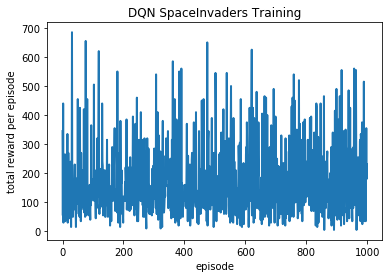

In [5]:
MODEL_LOG_DIR = './model_1208'
if not os.path.exists(MODEL_LOG_DIR):
    os.makedirs(MODEL_LOG_DIR)

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

ep_rewards = []       
agent = Agent(sess)
        
sess.run(tf.global_variables_initializer())      
saver = tf.train.Saver()
        
date_object = datetime.now()
current_time = date_object.strftime('%H:%M:%S')
print("Training starts -- {}".format(current_time))
        
for ep in range(1000): 
            
    last_observation = preprocess(env.reset())
    agent.set_total_reward(0)
    for t in range(10000):
                
        action = agent.choose_action(last_observation)
        observation, reward, done, info = env.step(action)
        observation = preprocess(observation)
                
        if done==True:
            observation = None
                
        agent.gather_reward(reward)
        agent.gather_experience(last_observation, action, reward, observation)
        agent.q_update()
        last_observation = observation
                
        if done==True:
            ep_rewards.append(agent.get_total_reward())
            break
                    
    # print('Episode #{} finished after {} steps, with reward {}'.format(ep+1, t+1, ep_rewards[ep]))
            
    if (ep+1) % 50 == 0:
        date_object = datetime.now()
        current_time = date_object.strftime('%H:%M:%S')
        print('After {} episodes, last 50 rewards averaged {} -- {}'.format(ep+1, np.mean(ep_rewards[-50:]), current_time))
            
    agent.set_epsilon(ep)
            
saver.save(sess, MODEL_LOG_DIR+'/trained_model', global_step=1000)
np.savetxt(MODEL_LOG_DIR+"/{}_rewards.csv".format(ep+1), ep_rewards, delimiter=",")

plt.plot(ep_rewards, linewidth=2)
plt.xlabel('episode')
plt.ylabel('total reward per episode')
plt.title('DQN SpaceInvaders Training')
plt.show()

### Testing

After 50 episodes, last 50 rewards averaged 221.5
After 100 episodes, last 50 rewards averaged 246.6
After 150 episodes, last 50 rewards averaged 246.4
After 200 episodes, last 50 rewards averaged 226.1


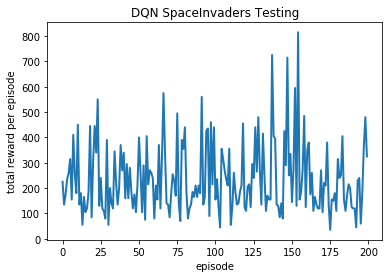

In [6]:
test_rewards = []
for ep in range(200): 
    
    last_observation = preprocess(env.reset())
    agent.set_total_reward(0)
    agent.reset_epsilon()
    
    for t in range(10000):
        action = agent.choose_action(last_observation)
        observation, reward, done, info = env.step(action)
        agent.gather_reward(reward)
        last_observation = preprocess(observation)
        if done==True or t == 9999:
            test_rewards.append(agent.get_total_reward())
            break
    
    if (ep+1) % 50 == 0:
        print('After {} episodes, last 50 rewards averaged {}'.format(ep+1, np.mean(test_rewards[-50:])))
        
plt.plot(test_rewards, linewidth=2)
plt.xlabel('episode')
plt.ylabel('total reward per episode')
plt.title('DQN SpaceInvaders Testing')
plt.show()

## Delayed-action model

In [ ]:
class Network:
    
    def __init__(self, session, w_in, h_in, c_in , n_out):
        self.session = session
        self.w_in = w_in
        self.h_in = h_in
        self.c_in = c_in
        self.n_out = n_out
        # data placeholders
        self.x = tf.placeholder(tf.float32, [None, self.w_in, self.h_in, self.c_in], name='x')
        self.y = tf.placeholder(tf.float32, [None, self.n_out], name='y')
        #self.pkeep = tf.placeholder(tf.float32, name='pkeep')
        
        self.x_in = tf.reshape(self.x, [-1,self.w_in,self.h_in,self.c_in])
        
        self.n1 = 8
        self.n2 = 16
        self.n3 = 32
        with tf.device("/device:GPU:0"):
             # cnn layer 1
            self.W_conv1 = tf.get_variable('W_conv1', shape=[7, 7, 1, self.n1])
            self.h_conv1 = tf.nn.conv2d(self.x_in,self.W_conv1,strides=[1,1,1,1],padding='SAME',name='conv1') 
            
            # cnn layer 2
            self.W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, self.n1, self.n2])
            self.h_conv2 = tf.nn.conv2d(self.h_conv1,self.W_conv2,strides=[1,1,1,1],padding='SAME',name='conv2')
            # pool 2
            self.h_pool = maxpool(self.h_conv2)
            # fc layer 
            self.h_pool_flat = tf.reshape(self.h_pool, [-1, 42*42*self.n2])
            self.W_fc1 = tf.get_variable('W_fc1', shape=[42*42*self.n2, self.n3])
            self.b_fc1 = tf.get_variable('b_fc1', shape=[self.n3])
            self.h_fc1 = tf.nn.relu(tf.add(tf.matmul(self.h_pool_flat, self.W_fc1), self.b_fc1),name='fc1')
            
            # one more fc layer
            self.W_fc2 = tf.get_variable('W_fc2', shape=[self.n3,self.n_out])
            self.b_fc2 = tf.get_variable('b_fc2', shape=[self.n_out])
            self.q = tf.add(tf.matmul(self.h_fc1, self.W_fc2), self.b_fc2, name='fc2')
            self.loss = tf.reduce_sum(tf.square(self.y - self.q),1)
            self.train_step = tf.train.AdamOptimizer(2*1e-4).minimize(self.loss)
        
    def compute(self, x):
        # evaluate the network and return the action values [q(s,a=0),q(s,a=1)]
        return self.session.run(self.q, feed_dict={self.x:np.reshape(x,[-1,self.w_in,self.h_in,self.c_in])})#self.pkeep:0.5
    
    def train(self, x_batch, y_batch):
        # take a training step
        _ = self.session.run(self.train_step, feed_dict={self.x: x_batch, self.y: y_batch})# self.pkeep: 0.5

### Training

In [ ]:
ep_rewards_train = []

sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
        #summary_writer = tf.summary.FileWriter(dir_name, sess.graph)
        
        
# create an agent
agent = Agent(sess)
# usual tf initialization
sess.run(tf.global_variables_initializer())      
####
# Q-learn (train) DQN on Space Invaders
####
for ep in range(1500): 
    # reset environment and agent
    last_observation = env.reset()
    last_observation = preprocess(last_observation)
    # change to gray scale and omit useless bottom part of the image to simplify computation
    agent.set_total_reward(0)
    # done at T==199 so no reason to go further
    action = agent.choose_action(last_observation)
    for t in range(10001):
        # agent chooses an action
        if (t+1)%4 == 0:
            action = agent.choose_action(last_observation)
                # agent takes the action, and the environment responds
            observation, reward, done, info = env.step(action)
            observation = preprocess(observation)
                # check for fail state
            if done==True:
                observation = None
                # update agent with reward and data
            agent.gather_reward(reward)
            agent.gather_experience(last_observation, action, reward, observation)
                # update q function, which will use the memory
            agent.q_update()
                # iterate
            last_observation = observation
        else:
            observation, reward, done, info = env.step(action)
            observation = preprocess(observation)
                # check for fail state
            if done==True:
                observation = None
                # update agent with reward and data
            agent.gather_reward(reward)
            agent.gather_experience(last_observation, action, reward, observation)
                # update q function, which will use the memory
            agent.q_update()
                # iterate
            last_observation = observation
                
                
        if done==True:
            ep_rewards_train.append(agent.get_total_reward())
                    #print('After {} steps, get total reward{}'.format(t,agent.get_total_reward()))
            break
                
            # print progress...
            #if (ep+1) % 50 == 0:
    print('At {} episodes, get total reward {}'.format(ep+1, agent.get_total_reward()))
            # update rates
    agent.set_epsilon(ep)
plt.plot(ep_rewards_train, linewidth=2)
plt.xlabel('episode')
plt.ylabel('total reward per episode')
plt.title('DQN SpaceInvader q-learning (training)')
plt.show()

### Testing

In [ ]:
test_rewards = []
for ep in range(200): 
    
    last_observation = preprocess(env.reset())
    agent.set_total_reward(0)
    agent.reset_epsilon()
    
    for t in range(10000):
        action = agent.choose_action(last_observation)
        observation, reward, done, info = env.step(action)
        agent.gather_reward(reward)
        last_observation = preprocess(observation)
        if done==True or t == 9999:
            test_rewards.append(agent.get_total_reward())
            break
    
    if (ep+1) % 50 == 0:
        print('After {} episodes, last 50 rewards averaged {}'.format(ep+1, np.mean(test_rewards[-50:])))
        
plt.plot(test_rewards, linewidth=2)
plt.xlabel('episode')
plt.ylabel('total reward per episode')
plt.title('DQN SpaceInvaders Testing')
plt.show()

## 5-Layer + stack-frame model

### use "SpaceInvaderDeterministic-v4" as environment

In [ ]:
env = gym.make('SpaceInvadersDeterministic-v4')

In [ ]:
class Agent: 
    
    def __init__(self, tf_session):
        self.image_size = (84, 84, 4)
        self.h, self.w, self.num_channels = self.image_size
        self.n_out = 6
        
        self.total_reward = 0 
        
        self.gamma = 0.99
        self.epsilon = 1
        self.batch_size = 36
        
        self.replay_buffer = Replay()
        
        self.q = Network(tf_session, self.image_size , self.n_out)           
        
    def gather_experience(self, last_observation, action, reward, observation):
        
        self.replay_buffer.write((last_observation, action, reward, observation))
            
    def choose_action(self, observation):
        
        if np.random.rand() > self.epsilon:
            q_compute = self.q.compute(observation)
            return np.argmax(q_compute)
        else:
            return np.random.choice(list(range(6)))
        
    def q_update(self):
        
        sars_batch = self.replay_buffer.read(self.batch_size)
        
        q_last = self.q.compute([s[0] for s in sars_batch])
        
        q_this = np.zeros_like(q_last)
        ind_not_none = [i for i in range(np.shape(sars_batch)[0]) if sars_batch[i][3] is not None]
        q_this_not_none = self.q.compute([sb[3] for sb in sars_batch if sb[3] is not None])
        
        for i in range(len(ind_not_none)):
            q_this[ind_not_none[i],:] = q_this_not_none[i,:]
        
        x_batch = np.zeros([np.shape(sars_batch)[0],self.h, self.w, self.num_channels])
        y_batch = np.zeros([np.shape(sars_batch)[0],self.n_out])
        for i in range(np.shape(sars_batch)[0]):
            x_batch[i,:] = sars_batch[i][0]
            for j in range(6):
                if j == sars_batch[i][1]:
                    y_batch[i,j] = sars_batch[i][2] + self.gamma*np.max(q_this[i])
                else:
                    y_batch[i,j] = q_last[i][j]
        
        self.q.train(x_batch,y_batch)

    def set_epsilon(self,episode):
        self.epsilon = 0.01 + (1.0 - 0.01)*np.exp(-.001*episode)
        
    def reset_epsilon(self):
        self.epsilon = 0.0

    def gather_reward(self, reward):
        self.total_reward += reward
    def get_total_reward(self):
         return self.total_reward
    def set_total_reward(self, new_total):
         self.total_reward = new_total

In [ ]:
class Network:
    
    def __init__(self, session, image_size, n_out):
        
        self.session = session
        self.image_size = image_size
        self.h, self.w, self.num_channels = self.image_size
        self.n_out = n_out
        
        self.n1 = 32
        self.n2 = 32
        self.n3 = 64
        self.n4 = 512
         
        self.x = tf.placeholder(tf.float32, [None, self.h, self.w, self.num_channels], name='x')
        self.y = tf.placeholder(tf.float32, [None, self.n_out], name='y')
        self.x_image = tf.reshape(self.x, [-1, self.h, self.w, self.num_channels])
        
        self.W_conv1 = tf.get_variable('W_conv1', initializer=wc1)
        self.b_conv1 = tf.get_variable('b_conv1', initializer=bc1)
        self.h_conv1 = tf.nn.relu(tf.add(conv(self.x_image, self.W_conv1), self.b_conv1))
        
        self.W_conv2 = tf.get_variable('W_conv2', initializer=wc2)
        self.b_conv2 = tf.get_variable('b_conv2', initializer=bc2)
        self.h_conv2 = tf.nn.relu(tf.add(conv(self.h_conv1, self.W_conv2), self.b_conv2))
       
        self.W_conv3 = tf.get_variable('W_conv3', initializer=wc3)
        self.b_conv3 = tf.get_variable('b_conv3', initializer=bc3)
        self.h_conv3 = tf.nn.relu(tf.add(conv(self.h_conv2, self.W_conv3), self.b_conv3))
        
        self.h_conv3_flat = tf.reshape(self.h_conv3, [-1, 121*self.n3])
        self.W_fc1 = tf.get_variable('W_fc1', initializer=wfc1)
        self.b_fc1 = tf.get_variable('b_fc1', initializer=b1)
        self.h_fc1 = tf.nn.relu(tf.add(tf.matmul(self.h_conv3_flat, self.W_fc1), self.b_fc1))
        
        self.W_fc2 = tf.get_variable('W_fc2', initializer=wfc2)
        self.b_fc2 = tf.get_variable('b_fc2', initializer=b2)
        self.q = tf.add(tf.matmul(self.h_fc1, self.W_fc2), self.b_fc2, name='q_values')
        
        
        self.loss = tf.reduce_sum(tf.square(self.y - self.q),1)
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss)
    
    def compute(self, x):
        
        return self.session.run(self.q, feed_dict={self.x:np.reshape(x,[-1, self.h, self.w, self.num_channels])})
    
    def train(self, x_batch, y_batch):
        
        _ = self.session.run(self.train_step, feed_dict={self.x: x_batch, self.y: y_batch})

### Training

In [ ]:
MODEL_LOG_DIR = './final_model'
if not os.path.exists(MODEL_LOG_DIR):
    os.makedirs(MODEL_LOG_DIR)

sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))

ep_rewards = []       
agent = Agent(sess)
        
sess.run(tf.global_variables_initializer())      
saver = tf.train.Saver()
        
date_object = datetime.now()
current_time = date_object.strftime('%H:%M:%S')
print("Training starts -- {}".format(current_time))
        
for ep in range(2500): 
    
    agent.set_total_reward(0)
    
    last_observation = preprocess(env.reset())[:,:,0]
    last_observation = np.stack((last_observation,last_observation,last_observation,last_observation), axis = 2)
    
    for t in range(10000):
        
        action = agent.choose_action(last_observation)
        
        observation_frame, reward_frame, done, info = env.step(action)
        observation_frame = preprocess(observation_frame)
        agent.gather_reward(reward_frame)
        
        observation = last_observation[:,:,[1,2,3,0]]
        observation[:,:,3] = observation_frame[:,:,0]
        
        if done==True:
            observation = None
            
        # if reward > 0, set reward to 1; otherwise, 0
        agent.gather_experience(last_observation, action, np.sign(reward_frame), observation)
        agent.q_update()
        
        last_observation = observation
                
        if done==True or t==9999:
            ep_rewards.append(agent.get_total_reward())
            break
                    
    # print('Episode #{} finished after {} steps, with reward {}'.format(ep+1, t+1, ep_rewards[ep]))
            
    if (ep+1) % 50 == 0:
        date_object = datetime.now()
        current_time = date_object.strftime('%H:%M:%S')
        print('After {} episodes, last 50 rewards averaged {} -- {}'.format(ep+1, np.mean(ep_rewards[-50:]), current_time))
            
    agent.set_epsilon(ep)
            
saver.save(sess, MODEL_LOG_DIR+'/trained_model', global_step=2500)
np.savetxt(MODEL_LOG_DIR+"/{}_rewards.csv".format(ep+1), ep_rewards, delimiter=",")

plt.plot(ep_rewards, linewidth=2)
plt.xlabel('episode')
plt.ylabel('total reward per episode')
plt.title('DQN SpaceInvaders Training')
plt.show()

### Testing

In [ ]:
test_rewards = []
for ep in range(200): 
    
    agent.set_total_reward(0)
    agent.epsilon = 0
    
    last_observation = preprocess(env.reset())[:,:,0]
    last_observation = np.stack((last_observation,last_observation,last_observation,last_observation), axis = 2)
    
    for t in range(10000):
        env.render()
        action = agent.choose_action(last_observation)
        
        observation_frame, reward_frame, done, info = env.step(action)
        observation_frame = preprocess(observation_frame)
        agent.gather_reward(reward_frame)
        
        last_observation = last_observation[:,:,[1,2,3,0]]
        last_observation[:,:,3] = observation_frame[:,:,0]
                
        if done==True or t==9999:
            test_rewards.append(agent.get_total_reward())
            break
         
    if (ep+1) % 50 == 0:
        date_object = datetime.now()
        current_time = date_object.strftime('%H:%M:%S')
        print('After {} episodes, last 50 rewards averaged {} -- {}'.format(ep+1, np.mean(test_rewards[-50:]), current_time))

plt.plot(test_rewards, linewidth=2)
plt.xlabel('episode')
plt.ylabel('total reward per episode')
plt.title('DQN SpaceInvaders Testing')
plt.show()

## use stored model to test

In [ ]:
sess = tf.Session()
saver = tf.train.import_meta_graph("./final_model/trained_model-3000.meta")
saver.restore(sess,tf.train.latest_checkpoint("./final_model/"))
wc1=sess.run('W_conv1:0')
wc2=sess.run('W_conv2:0')
wc3=sess.run("W_conv3:0")
bc1=sess.run("b_conv1:0")
bc2=sess.run("b_conv2:0")
bc3=sess.run("b_conv3:0")
wfc1=sess.run('W_fc1:0')
wfc2=sess.run('W_fc2:0')
b1=sess.run('b_fc1:0')
b2=sess.run('b_fc2:0')

### initialize networks

In [ ]:
class Network:
    
    def __init__(self, session, image_size, n_out):
        
        self.session = session
        self.image_size = image_size
        self.h, self.w, self.num_channels = self.image_size
        self.n_out = n_out
        
        self.n1 = 32
        self.n2 = 32
        self.n3 = 64
        self.n4 = 512
         
        self.x = tf.placeholder(tf.float32, [None, self.h, self.w, self.num_channels], name='x')
        self.y = tf.placeholder(tf.float32, [None, self.n_out], name='y')
        self.x_image = tf.reshape(self.x, [-1, self.h, self.w, self.num_channels])
        
        self.W_conv1 = tf.get_variable('W_conv1', initializer=wc1)
        self.b_conv1 = tf.get_variable('b_conv1', initializer=bc1)
        self.h_conv1 = tf.nn.relu(tf.add(conv(self.x_image, self.W_conv1), self.b_conv1))
        
        self.W_conv2 = tf.get_variable('W_conv2', initializer=wc2)
        self.b_conv2 = tf.get_variable('b_conv2', initializer=bc2)
        self.h_conv2 = tf.nn.relu(tf.add(conv(self.h_conv1, self.W_conv2), self.b_conv2))
       
        self.W_conv3 = tf.get_variable('W_conv3', initializer=wc3)
        self.b_conv3 = tf.get_variable('b_conv3', initializer=bc3)
        self.h_conv3 = tf.nn.relu(tf.add(conv(self.h_conv2, self.W_conv3), self.b_conv3))
        
        self.h_conv3_flat = tf.reshape(self.h_conv3, [-1, 121*self.n3])
        self.W_fc1 = tf.get_variable('W_fc1', initializer=wfc1)
        self.b_fc1 = tf.get_variable('b_fc1', initializer=b1)
        self.h_fc1 = tf.nn.relu(tf.add(tf.matmul(self.h_conv3_flat, self.W_fc1), self.b_fc1))
        
        self.W_fc2 = tf.get_variable('W_fc2', initializer=wfc2)
        self.b_fc2 = tf.get_variable('b_fc2', initializer=b2)
        self.q = tf.add(tf.matmul(self.h_fc1, self.W_fc2), self.b_fc2, name='q_values')
        
        
        self.loss = tf.reduce_sum(tf.square(self.y - self.q),1)
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss)
    
    def compute(self, x):
        
        return self.session.run(self.q, feed_dict={self.x:np.reshape(x,[-1, self.h, self.w, self.num_channels])})
    
    def train(self, x_batch, y_batch):
        
        _ = self.session.run(self.train_step, feed_dict={self.x: x_batch, self.y: y_batch})

In [ ]:
agent = Agent(sess)
sess.run(tf.global_variables_initializer())

In [ ]:
test_rewards = []
for ep in range(200): 
    
    agent.set_total_reward(0)
    agent.epsilon = 0
    
    last_observation = preprocess(env.reset())[:,:,0]
    last_observation = np.stack((last_observation,last_observation,last_observation,last_observation), axis = 2)
    
    for t in range(10000):
        env.render()
        action = agent.choose_action(last_observation)
        
        observation_frame, reward_frame, done, info = env.step(action)
        observation_frame = preprocess(observation_frame)
        agent.gather_reward(reward_frame)
        
        last_observation = last_observation[:,:,[1,2,3,0]]
        last_observation[:,:,3] = observation_frame[:,:,0]
                
        if done==True or t==9999:
            test_rewards.append(agent.get_total_reward())
            break
         
    if (ep+1) % 50 == 0:
        date_object = datetime.now()
        current_time = date_object.strftime('%H:%M:%S')
        print('After {} episodes, last 50 rewards averaged {} -- {}'.format(ep+1, np.mean(test_rewards[-50:]), current_time))

plt.plot(test_rewards, linewidth=2)
plt.xlabel('episode')
plt.ylabel('total reward per episode')
plt.title('DQN SpaceInvaders Testing')
plt.show()